Task 1

In [173]:
import numpy as np

def generate_inter_arrivals(lam):
    return np.random.exponential(scale = 1/lam)

def generate_length_of_stay(mean_length):
    return np.random.exponential(scale = mean_length)


def simulate_arrival_time(lam, n_days):
    arrival_sum = 0
    times = []
    while arrival_sum < n_days:
        new_time = generate_inter_arrivals(lam)
        new_sum = arrival_sum + new_time
        if compute_day(new_sum) >= n_days:
            break
        arrival_sum += new_time
        times.append(new_time)
    
    times = np.array(times)
    arrival_times = np.cumsum(times)
    return arrival_times

def choose_new_ward(i, P):
    prob = P[i,:]
    choices = P.shape[0]
    new_ward = np.random.choice(np.arange(0,choices), p= prob)
    return new_ward

def generate_list_of_arrivals(arrival_times, keys):
    arrival_tuples = []
    for i, key in enumerate(keys):
        for t in arrival_times[i]:  
            arrival_tuples.append((t, key)) 

    arrival_tuples.sort(key=lambda x: x[0])
    return arrival_tuples 

def add_leaving_time(leaving_times, leaving_time_and_ward):
    leaving_times.append(leaving_time_and_ward)
    leaving_times.sort(key=lambda x: x[0])

def remove_free_beds(leaving_times, arr_time, available_beds):
    to_remove = [lt for lt in leaving_times if arr_time >= lt[0]]
    for lt in to_remove:
            leaving_times.remove(lt)
            available_beds[lt[1]] += 1

def handle_patient(available_beds, leaving_times, arr_time, next_ward, mean_length):
    available_beds[next_ward] -= 1
    degency_time = generate_length_of_stay(mean_length[next_ward])
    leaving_time = arr_time + degency_time
    add_leaving_time(leaving_times, (leaving_time, next_ward))

def compute_day(arr_time):
    day = int(np.floor(arr_time))
    return day


In [174]:
P = np.array([
    [0.00, 0.05, 0.10, 0.05, 0.80],
    [0.20, 0.00, 0.50, 0.15, 0.15],
    [0.30, 0.20, 0.00, 0.20, 0.30],
    [0.35, 0.30, 0.05, 0.00, 0.30],
    [0.20, 0.10, 0.60, 0.10, 0.00],
    ])


In [175]:
# Simulate
def simulate(lams, mean_length, n_days, available_beds, penalty):


    arrival_times = [simulate_arrival_time(lam, n_days) for lam in lams]
    wards = np.arange(0, P.shape[1])
    event_list = generate_list_of_arrivals(arrival_times, wards)
    leaving_times = []
    rejected_patients = np.zeros(n_days)
    total_rejected = [0]
    available_beds_matrix = available_beds.reshape(1, -1)  # Shape: (1, n_wards)
    days = []
    relocation_matrix = np.zeros(P.shape)
    computed_penalty = np.zeros(penalty.shape)

    for j in range(len(event_list)):
        arr_time, next_ward = event_list[j]
        day = compute_day(arr_time)
        days.append(day)
        
        if j >= 1:
            previous_day = compute_day(event_list[j-1][0])
        else: previous_day = 0

        # Remove patients who have already left before the current arrival time
        remove_free_beds(leaving_times, arr_time, available_beds)
            

        # Check if there are avaiable beds
        if available_beds[next_ward] > 0:
            handle_patient(available_beds, leaving_times, arr_time, next_ward, mean_length)
        # If there are no beds available, send the patient to another ward with probability p_ij
        else:
            computed_penalty[next_ward] += penalty[next_ward]
            old_ward = next_ward
            next_ward =  choose_new_ward(next_ward, P)
            relocation_matrix[old_ward, next_ward] += 1
            if available_beds[next_ward] > 0:
                handle_patient(available_beds, leaving_times, arr_time, next_ward, mean_length)
                #print('patient handled by another ward')
            else: 
                rejected_patients[day] += 1
                total_rejected.append(total_rejected[-1]+1)
                #print('patient rejected')
                continue
       
        available_beds_matrix = np.vstack([available_beds_matrix, available_beds.reshape(1, -1)])

    return available_beds_matrix, rejected_patients, relocation_matrix, computed_penalty

In [176]:
lams = [14.5, 11.0, 8.0, 6.5, 5.0]

mean_length = [2.9, 4.0, 4.5, 1.4, 3.9]

n_days = 100

available_beds = np.array([55, 40, 30, 20, 20])

penalty = np.array([7, 5, 2, 10, 5])

available_beds_matrix, rejected_patients, relocation_matrix, penaltys = simulate(lams, mean_length, n_days, available_beds, penalty)

In [177]:
#print(available_beds_matrix)
#print(rejected_patients)
print(relocation_matrix)
#print(penaltys)
print(P)
print("Sum by rows of relocation matrix:", np.sum(relocation_matrix, axis=1))


[[ 0.  4.  6.  3. 55.]
 [37.  0. 92. 30. 28.]
 [67. 36.  0. 48. 79.]
 [ 2.  0.  0.  0.  0.]
 [22. 13. 94. 19.  0.]]
[[0.   0.05 0.1  0.05 0.8 ]
 [0.2  0.   0.5  0.15 0.15]
 [0.3  0.2  0.   0.2  0.3 ]
 [0.35 0.3  0.05 0.   0.3 ]
 [0.2  0.1  0.6  0.1  0.  ]]
Sum by rows of relocation matrix: [ 68. 187. 230.   2. 148.]


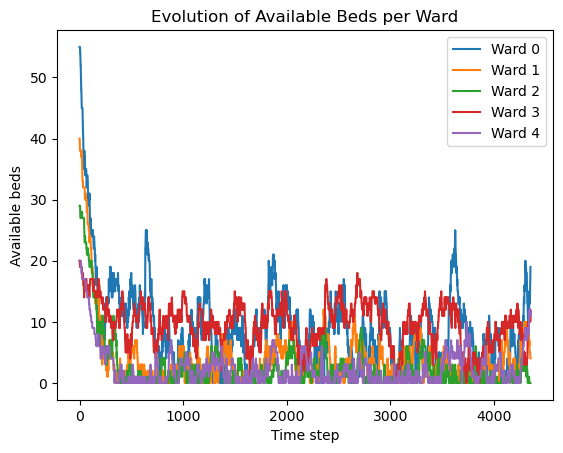

In [178]:
import matplotlib.pyplot as plt

for ward_idx in range(available_beds_matrix.shape[1]):
    plt.plot(available_beds_matrix[:, ward_idx], label=f'Ward {ward_idx}')
plt.xlabel('Time step')
plt.ylabel('Available beds')
plt.title('Evolution of Available Beds per Ward')
plt.legend()
plt.show()


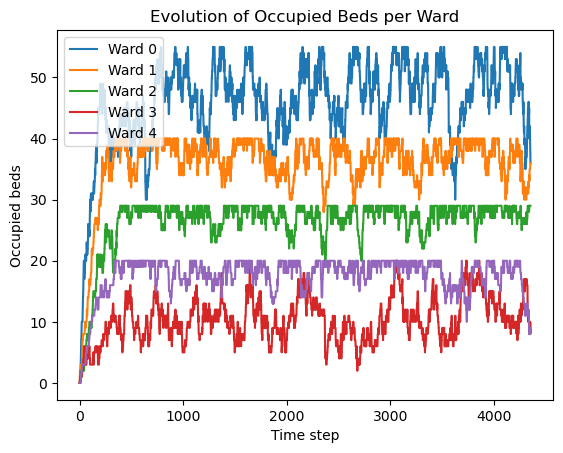

In [179]:
initial_beds = available_beds_matrix[0]
occupied_beds_matrix = initial_beds - available_beds_matrix

for ward_idx in range(occupied_beds_matrix.shape[1]):
    plt.plot(occupied_beds_matrix[:, ward_idx], label=f'Ward {ward_idx}')
plt.xlabel('Time step')
plt.ylabel('Occupied beds')
plt.title('Evolution of Occupied Beds per Ward')
plt.legend()
plt.show()

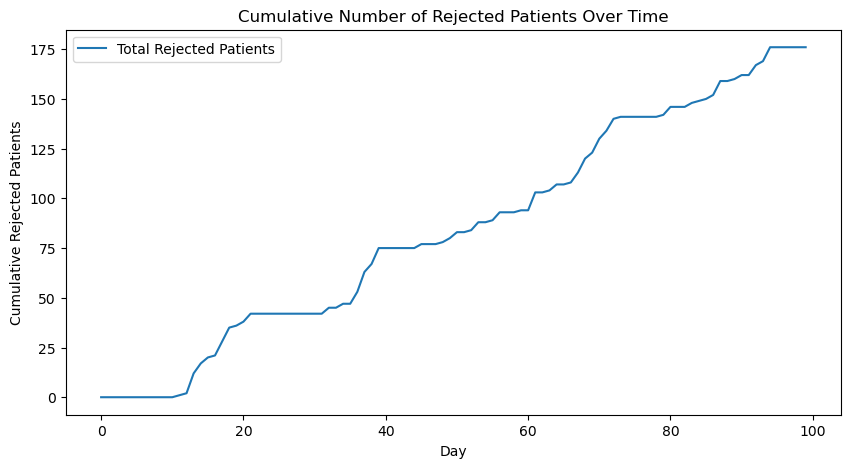

In [180]:
total_rejected = np.cumsum(rejected_patients)
plt.figure(figsize=(10, 5))
plt.plot(total_rejected, label='Total Rejected Patients')
plt.xlabel('Day')
plt.ylabel('Cumulative Rejected Patients')
plt.title('Cumulative Number of Rejected Patients Over Time')
plt.legend()
plt.show()

Task 2

We need to find the minimum number of beds to give to ward F in order to have an acceptance rate of 95%

To do so, we use Erlang's-B formula 
A = lams * mean service time = 13.0 * 2.2
To use the formula to compute the probability of blocking, and we should make sure that the the probabily of blocking is less the 5%


In [181]:
from scipy.special import factorial

lam = 13.0
mean_length = 2.2
A = lam * mean_length
m_vector = np.arange(10,50)

def block_prob(A, m):
    nominator = A ** m / (factorial(m))
    denominator =  sum(A**i/factorial(i) for i in range(0,m+1))
    return nominator / denominator

for m in m_vector:
    p = block_prob(A,m)
    print(f'Probability of blocking with {m} beds is: {p}')
    if p <= 0.05:
        print(f'found p = {p} => number of beds = {m}')
        break


Probability of blocking with 10 beds is: 0.6667154065199613
Probability of blocking with 11 beds is: 0.6341633024939435
Probability of blocking with 12 beds is: 0.60181929363769
Probability of blocking with 13 beds is: 0.5697078539138748
Probability of blocking with 14 beds is: 0.5378568615721447
Probability of blocking with 15 beds is: 0.5062980933615348
Probability of blocking with 16 beds is: 0.4750677776679584
Probability of blocking with 17 beds is: 0.4442072052218292
Probability of blocking with 18 beds is: 0.41376339088674924
Probability of blocking with 19 beds is: 0.3837897722685502
Probability of blocking with 20 beds is: 0.3543469196183506
Probability of blocking with 21 beds is: 0.325503215817002
Probability of blocking with 22 beds is: 0.2973354442840266
Probability of blocking with 23 beds is: 0.2699291960117923
Probability of blocking with 24 beds is: 0.24337897506199982
Probability of blocking with 25 beds is: 0.21778784695106335
Probability of blocking with 26 beds is:

In [182]:
def simulate_t2(lams, mean_length, n_days, available_beds, penalty):

    rejected_F = 0
    total_patients_F = 0
    arrival_times = [simulate_arrival_time(lam, n_days) for lam in lams]
    wards = np.arange(0, P.shape[1])
    event_list = generate_list_of_arrivals(arrival_times, wards)
    leaving_times = []
    rejected_patients = np.zeros(n_days)
    rejections = np.zeros(P.shape[0])
    total_rejected = [0]
    available_beds_matrix = available_beds.reshape(1, -1)  # Shape: (1, n_wards)
    days = []
    relocation_matrix = np.zeros(P.shape)
    computed_penalty = np.zeros(penalty.shape, dtype = int)

    for j in range(len(event_list)):
        arr_time, next_ward = event_list[j]
        day = compute_day(arr_time)
        days.append(day)
        if next_ward == 5: total_patients_F += 1
        
        if j >= 1:
            previous_day = compute_day(event_list[j-1][0])
        else: previous_day = 0

        # Remove patients who have already left before the current arrival time
        remove_free_beds(leaving_times, arr_time, available_beds)
            

        # Check if there are avaiable beds
        if available_beds[next_ward] > 0:
            handle_patient(available_beds, leaving_times, arr_time, next_ward, mean_length)
        # If there are no beds available, send the patient to another ward with probability p_ij
        else:
            computed_penalty[next_ward] += penalty[next_ward]
            old_ward = next_ward
            next_ward =  choose_new_ward(next_ward, P)
            

            if old_ward == 5: rejected_F += 1

            if available_beds[next_ward] > 0:
                relocation_matrix[old_ward, next_ward] += 1
                handle_patient(available_beds, leaving_times, arr_time, next_ward, mean_length)
                #print('patient handled by another ward')
            else: 
                rejected_patients[day] += 1
                rejections[old_ward] += 1
                total_rejected.append(total_rejected[-1]+1)
                #print('patient rejected')
                continue
       
        available_beds_matrix = np.vstack([available_beds_matrix, available_beds.reshape(1, -1)])
    acceptance_rate_F =1 -(rejected_F / total_patients_F)
    total_penalty = np.sum(computed_penalty)

    return available_beds_matrix, rejected_patients, relocation_matrix, computed_penalty, total_penalty, acceptance_rate_F, event_list, rejections

In [183]:
P = np.array([
    [0.00, 0.05, 0.10, 0.05, 0.80, 0.00],
    [0.20, 0.00, 0.50, 0.15, 0.15, 0.00],
    [0.30, 0.20, 0.00, 0.20, 0.30, 0.00],
    [0.35, 0.30, 0.05, 0.00, 0.30, 0.00],
    [0.20, 0.10, 0.60, 0.10, 0.00, 0.00],
    [0.20, 0.20, 0.20, 0.20, 0.20, 0.00]
    ])

lams = [14.5, 11.0, 8.0, 6.5, 5.0, 13.0]

mean_length = [2.9, 4.0, 4.5, 1.4, 3.9, 2.2]

n_days = 100

available_beds = np.array([55, 40, 30, 20, 20, 34])

penalty = np.array([7, 5, 2, 10, 5, 0])

In [184]:
available_beds_matrix, rejected_patients, relocation_matrix, penaltys,total_penalty, acceptance_rate_F, event_list, rejections = simulate_t2(lams, mean_length, n_days, available_beds, penalty)

In [185]:
print(acceptance_rate_F)

0.9227272727272727


In [186]:
# Use simulated annealing to find the distribution of beds, i.e. where shuld we take the beds away from to give them to ward F
# Idea: Start from a configuration of beds, then compute the penalty, and use it in the Simulated Annealing to
# evaluate the solution. Accept only simulations where 95% of patients are accepted in F
import random

def cooling_scheme(k):
    return 1 / np.sqrt(1 + k)

def generate_new_guess(current_guess):
    current_guess = np.array(current_guess)
    total_beds = np.sum(current_guess)

    # Last value is fixed
    fixed_value = current_guess[-1]
    modifiable = current_guess[:-1]

    # Choose two indices to shift beds between
    i, j = random.sample(range(len(modifiable)), 2)

    # Decide how many beds to move (small amount)
    max_transfer = min(modifiable[i], 5)
    if max_transfer == 0:
        return current_guess.copy()  # can't move anything
    delta = random.randint(1, max_transfer)

    # Apply the move
    new_modifiable = modifiable.copy()
    new_modifiable[i] -= delta
    new_modifiable[j] += delta

    # Combine modified part with fixed part
    new_guess = np.append(new_modifiable, fixed_value)

    # Sanity check (optional)
    assert np.sum(new_guess) == total_beds
    assert new_guess[-1] == fixed_value

    return new_guess



In [187]:
# Implementation of SA

P = np.array([
    [0.00, 0.05, 0.10, 0.05, 0.80, 0.00],
    [0.20, 0.00, 0.50, 0.15, 0.15, 0.00],
    [0.30, 0.20, 0.00, 0.20, 0.30, 0.00],
    [0.35, 0.30, 0.05, 0.00, 0.30, 0.00],
    [0.20, 0.10, 0.60, 0.10, 0.00, 0.00],
    [0.20, 0.20, 0.20, 0.20, 0.20, 0.00]
    ])

lams = [14.5, 11.0, 8.0, 6.5, 5.0, 13.0]

mean_length = [2.9, 4.0, 4.5, 1.4, 3.9, 2.2]

n_days = 100

initial_beds = np.array([55, 40, 30, 20, 20])
total_beds = np.sum(initial_beds)
beds_ward6 = 34
parts = 5
min_beds = 1

remaining = beds_ward6- parts * min_beds
cuts = np.sort(np.random.choice(range(1, remaining + parts), parts - 1, replace=False))
split = np.diff([0] + cuts.tolist() + [remaining])
split = split + min_beds

bed_alloc_guess = initial_beds - split
bed_alloc_guess = np.append(bed_alloc_guess, beds_ward6)
print(bed_alloc_guess)
print(np.sum(bed_alloc_guess))



[52 35 28  6 10 34]
165


In [188]:
# Run the simulated annealing to find the optimal distrbibution

N_iter = 100

costs = np.empty(N_iter)

penalty = np.array([7, 5, 2, 10, 5, 0])

available_beds_matrix, rejected_patients, relocation_matrix, penaltys,total_penalty_guess, acceptance_rate_F,event_list, rejections = simulate_t2(lams, mean_length, n_days, np.copy(bed_alloc_guess), penalty)
print(f'Starting distribution: {bed_alloc_guess}, with penalty: {total_penalty_guess}')

for n in range(N_iter):
    T = cooling_scheme(n)

    remaining = beds_ward6- parts * min_beds
    cuts = np.sort(np.random.choice(range(1, remaining + parts), parts - 1, replace=False))
    split = np.diff([0] + cuts.tolist() + [remaining])
    split = split + min_beds

    new_proposal = generate_new_guess(bed_alloc_guess)
    
    print(new_proposal)
    print(np.sum(new_proposal))

    available_beds_matrix, rejected_patients, relocation_matrix, penaltys,total_penalty_new, acceptance_rate_F,event_list, rejections = simulate_t2(lams, mean_length, n_days, np.copy(new_proposal), penalty)

    diff_energy = total_penalty_new - total_penalty_guess

    u = np.random.uniform(0, 1)
    if diff_energy <= 0:
        bed_alloc_guess = new_proposal
        total_penalty_guess = total_penalty_new
    elif u < np.exp( - diff_energy / T):
        bed_alloc_guess = new_proposal
        total_penalty_guess = total_penalty_new

    print(bed_alloc_guess)
    print(np.sum(bed_alloc_guess))
    costs[n] = total_penalty_guess


Starting distribution: [52 35 28  6 10 34], with penalty: 8501
[52 35 28  3 13 34]
165
[52 35 28  6 10 34]
165
[52 40 28  6  5 34]
165
[52 35 28  6 10 34]
165
[55 35 25  6 10 34]
165
[52 35 28  6 10 34]
165
[56 35 28  2 10 34]
165
[52 35 28  6 10 34]
165
[52 37 26  6 10 34]
165
[52 37 26  6 10 34]
165
[52 38 26  5 10 34]
165
[52 37 26  6 10 34]
165
[57 32 26  6 10 34]
165
[52 37 26  6 10 34]
165
[52 35 26  8 10 34]
165
[52 35 26  8 10 34]
165
[52 36 25  8 10 34]
165
[52 36 25  8 10 34]
165
[55 36 25  8  7 34]
165
[52 36 25  8 10 34]
165
[52 36 29  4 10 34]
165
[52 36 25  8 10 34]
165
[52 36 23 10 10 34]
165
[52 36 23 10 10 34]
165
[52 38 21 10 10 34]
165
[52 36 23 10 10 34]
165
[47 41 23 10 10 34]
165
[47 41 23 10 10 34]
165
[52 36 23 10 10 34]
165
[47 41 23 10 10 34]
165
[47 38 23 10 13 34]
165
[47 41 23 10 10 34]
165
[47 41 25  8 10 34]
165
[47 41 23 10 10 34]
165
[47 40 23 10 11 34]
165
[47 41 23 10 10 34]
165
[47 41 22 11 10 34]
165
[47 41 22 11 10 34]
165
[49 41 20 11 10 34]
165
[


Best configuration found:
Beds: [45 42 17 16 11 34]
Acceptance rate F*: 0.9690162664601084
Total penalty: 5134


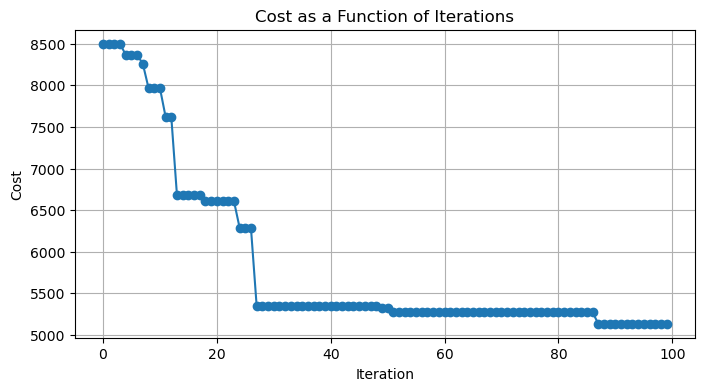

In [189]:
print("\nBest configuration found:")
print("Beds:", bed_alloc_guess)
print("Acceptance rate F*:", acceptance_rate_F)
print("Total penalty:", total_penalty_guess)

plt.figure(figsize=(8, 4))
plt.plot(np.arange(N_iter), costs, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost as a Function of Iterations')
plt.grid(True)
plt.show()

In [190]:
print(costs)

[8501. 8501. 8501. 8501. 8367. 8367. 8367. 8260. 7970. 7970. 7970. 7623.
 7623. 6678. 6678. 6678. 6678. 6678. 6611. 6611. 6611. 6611. 6611. 6611.
 6289. 6280. 6280. 5344. 5344. 5344. 5344. 5344. 5344. 5344. 5344. 5344.
 5344. 5344. 5344. 5344. 5344. 5344. 5344. 5344. 5344. 5344. 5344. 5344.
 5344. 5325. 5325. 5271. 5271. 5271. 5271. 5271. 5271. 5271. 5271. 5271.
 5271. 5271. 5271. 5271. 5271. 5271. 5271. 5271. 5271. 5271. 5271. 5271.
 5271. 5271. 5271. 5271. 5271. 5271. 5271. 5271. 5271. 5271. 5271. 5271.
 5271. 5271. 5271. 5134. 5134. 5134. 5134. 5134. 5134. 5134. 5134. 5134.
 5134. 5134. 5134. 5134.]


In [191]:
P = np.array([
    [0.00, 0.05, 0.10, 0.05, 0.80, 0.00],
    [0.20, 0.00, 0.50, 0.15, 0.15, 0.00],
    [0.30, 0.20, 0.00, 0.20, 0.30, 0.00],
    [0.35, 0.30, 0.05, 0.00, 0.30, 0.00],
    [0.20, 0.10, 0.60, 0.10, 0.00, 0.00],
    [0.20, 0.20, 0.20, 0.20, 0.20, 0.00]
    ])

lams = [14.5, 11.0, 8.0, 6.5, 5.0, 13.0]

mean_length = [2.9, 4.0, 4.5, 1.4, 3.9, 2.2]

n_days = 100

available_beds = bed_alloc_guess

penalty = np.array([7, 5, 2, 10, 5, 0])

Task 3

In [192]:
available_beds_matrix, rejected_patients, relocation_matrix, penaltys,total_penalty, acceptance_rate_F, event_list,rejections = simulate_t2(lams, mean_length, n_days, np.copy(available_beds), penalty)

In [193]:
#print(available_beds_matrix)
#print(rejected_patients)
print(relocation_matrix)
#print(penaltys)
print(P)
print(bed_alloc_guess)
print("Sum by rows of relocation matrix:", np.sum(relocation_matrix, axis=1))
print(acceptance_rate_F)

[[  0.   9.   4.  17.  55.   0.]
 [ 36.   0.  31.  26.   9.   0.]
 [134.  84.   0. 102.  58.   0.]
 [ 10.  11.   1.   0.   3.   0.]
 [ 66.  26.  70.  37.   0.   0.]
 [ 15.   5.   6.  17.   5.   0.]]
[[0.   0.05 0.1  0.05 0.8  0.  ]
 [0.2  0.   0.5  0.15 0.15 0.  ]
 [0.3  0.2  0.   0.2  0.3  0.  ]
 [0.35 0.3  0.05 0.   0.3  0.  ]
 [0.2  0.1  0.6  0.1  0.   0.  ]
 [0.2  0.2  0.2  0.2  0.2  0.  ]]
[45 42 17 16 11 34]
Sum by rows of relocation matrix: [ 85. 102. 378.  25. 199.  48.]
0.9419117647058823


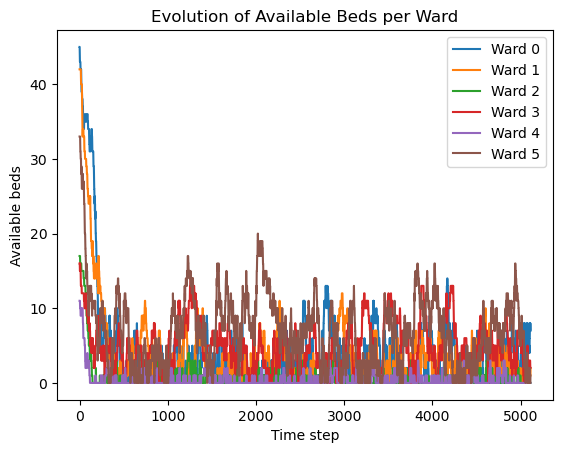

In [194]:
import matplotlib.pyplot as plt

for ward_idx in range(available_beds_matrix.shape[1]):
    plt.plot(available_beds_matrix[:, ward_idx], label=f'Ward {ward_idx}')
plt.xlabel('Time step')
plt.ylabel('Available beds')
plt.title('Evolution of Available Beds per Ward')
plt.legend()
plt.show()

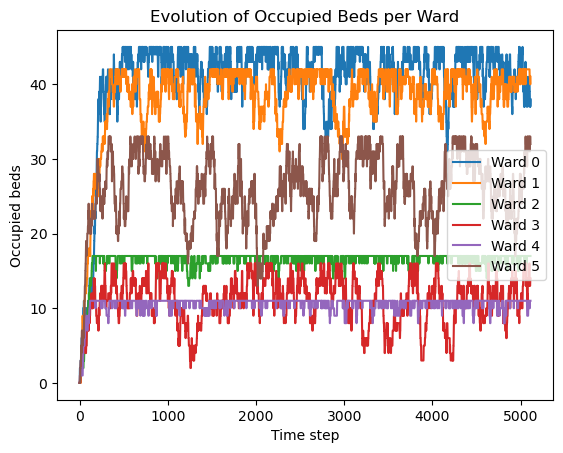

In [195]:
initial_beds = available_beds_matrix[0]
occupied_beds_matrix = initial_beds - available_beds_matrix

for ward_idx in range(occupied_beds_matrix.shape[1]):
    plt.plot(occupied_beds_matrix[:, ward_idx], label=f'Ward {ward_idx}')
plt.xlabel('Time step')
plt.ylabel('Occupied beds')
plt.title('Evolution of Occupied Beds per Ward')
plt.legend()
plt.show()

Implications of adding a new ward F:

Looking at the relocation matrix, we see that, since we chose F s.t. we have an acceptance rate around 95%, there are not many patients
who are sent to other wards, when they should go to F.
As a matter of fact, ward F is the one with the lowest rejections, together with ward D which has the lowest mean time stay.

Furthermore, the patients are sent evenly to other wards, when the come from ward F, as represented by the probabilties in the P matrix.

Most importantly, adding ward F with these conditions: high acceptance rate, and no patients can be sent to it, implies that in the other
wards the rejections are way higher, as well as the relocations between these wards.


Primary performance measures

In [196]:
available_beds = np.array([41, 45, 20, 16, 9, 34])
available_beds_matrix, rejected_patients, relocation_matrix, penaltys,total_penalty, acceptance_rate_F, event_list,rejections = simulate_t2(lams, mean_length, n_days, np.copy(available_beds), penalty)

In [ ]:
from collections import Counter

# Estimate probability that all beds are occupied on arrival, for each ward

# Count occurrences of each ward index in event_list
ward_counts = Counter(ward for _, ward in event_list)
n_wards = len(lams)
ward_counts_arr = np.array([ward_counts.get(ward_idx, 0) for ward_idx in range(n_wards)])


reallocations = np.sum(relocation_matrix, axis=1)

p_of_occupation = (reallocations + rejections) / ward_counts_arr
print(p_of_occupation)






[0.23878537 0.15115207 0.57496902 0.04952077 0.69214437 0.03030303]
